In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# 한글 깨짐 방지
# !pip install koreanize-matplotlib
import koreanize_matplotlib

In [2]:
# 개별 파일 경로

file_F = "output/tfidf/tnic_edges_2024.jsonl"
df_F = pd.read_json(file_F, lines=True)
df_F


file_T = 'evaluation/evaluation_metrics_1201.xlsx'
df_T = pd.read_excel(file_T)
df_T

,Symbol,PeerName,year,K,W,ROA(당기순이익)(%),ROE(당기순이익)(%),매출액_YoY,영업이익_YoY
0,A005930,삼성전자,2004,제조업,IT,14.84,30.56,NaN,NaN
1,A005930,삼성전자,2005,제조업,IT,9.63,17.71,-0.016270,-0.355866
2,A005930,삼성전자,2006,제조업,IT,10.52,18.30,0.064556,0.205073
3,A005930,삼성전자,2007,제조업,IT,9.07,15.25,0.147647,-0.017060
4,A005930,삼성전자,2008,제조업,IT,5.93,9.91,0.231317,-0.327798
...,...,...,...,...,...,...,...,...,...
36951,A950110,SBI핀테크솔루션즈,2023,정보통신업,IT,0.02,0.18,-0.002957,-0.883058
36952,A950110,SBI핀테크솔루션즈,2024,정보통신업,IT,0.05,0.48,-0.111661,-9.392762
36953,A950180,SNK,2019,정보통신업,커뮤니케이션서비스,6.70,7.12,-0.157430,-0.492863
36954,A950180,SNK,2020,정보통신업,커뮤니케이션서비스,-3.56,-3.88,-0.185772,-0.802353


In [3]:
import pandas as pd

def merge_with_T(df_input, df_T):
    """
    df_input: df_F, df_B, df_L 중 하나
    df_T: 기준 재무데이터 (PeerName, year, K, W 포함)
    """
    # df_T에서 필요한 컬럼만 추출
    t_base = df_T[['PeerName', 'year', 'K', 'W']].copy()

    # 1) 기업 i 기준 merge
    t_i = t_base.rename(columns={
        'PeerName': 'firm_i_name',
        'K': 'K_i',
        'W': 'W_i'
    })
    df_m = df_input.merge(
        t_i, how='left',
        on=['firm_i_name', 'year']
    )

    # 2) 기업 j 기준 merge
    t_j = t_base.rename(columns={
        'PeerName': 'firm_j_name',
        'K': 'K_j',
        'W': 'W_j'
    })
    df_m = df_m.merge(
        t_j, how='left',
        on=['firm_j_name', 'year']
    )

    return df_m
df_F_m = merge_with_T(df_F, df_T)
df_F_m

,year,firm_i,firm_i_name,firm_j,firm_j_name,similarity,K_i,W_i,K_j,W_j
0,2024,000270,기아,None,현대자동차,0.319058,제조업,경기관련소비재,NaN,NaN
1,2024,000270,기아,None,현대모비스,0.439446,제조업,경기관련소비재,제조업,경기관련소비재
2,2024,000270,기아,None,SNT홀딩스,0.219672,제조업,경기관련소비재,"전문, 과학 및 기술 서비스업",경기관련소비재
3,2024,000270,기아,None,HL홀딩스,0.269922,제조업,경기관련소비재,"전문, 과학 및 기술 서비스업",경기관련소비재
4,2024,000270,기아,005710,대원산업,0.306609,제조업,경기관련소비재,제조업,경기관련소비재
...,...,...,...,...,...,...,...,...,...,...
29359,2024,950170,JTC,950170,JTC,0.376557,도매 및 소매업,경기관련소비재,도매 및 소매업,경기관련소비재
29360,2024,950170,JTC,9830,한화솔루션,0.441820,도매 및 소매업,경기관련소비재,제조업,에너지
29361,2024,950170,JTC,990,DB하이텍,0.492709,도매 및 소매업,경기관련소비재,제조업,IT
29362,2024,9830,한화솔루션,990,DB하이텍,0.277954,제조업,에너지,제조업,IT


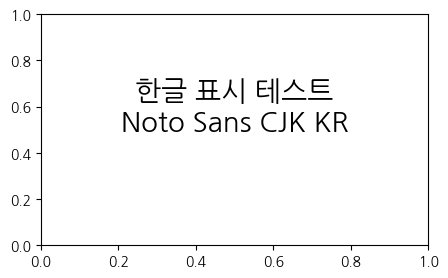

In [4]:
plt.figure(figsize=(5,3))
plt.text(0.5, 0.5, "한글 표시 테스트\nNoto Sans CJK KR", fontsize=20, ha='center')
plt.show()


In [5]:
# 관심 있는 기업 이름으로 바꿔서 쓰면 됨
center_name = "동성화인텍"
sim_threshold = 0.23  # similarity 컷
top_k_per_node = 5    # 노드당 최대 엣지 수

df = df_F_m.copy()

# 1) threshold로 1차 필터
df = df[df['similarity'] >= sim_threshold].copy()

# 2) center_name이 들어간 엣지만 먼저 선택
mask_center = (df['firm_i_name'] == center_name) | (df['firm_j_name'] == center_name)
df_center = df[mask_center].copy()

# 3) center의 이웃들 리스트
neighbors = pd.unique(
    df_center.loc[df_center['firm_i_name'] != df_center['firm_j_name'],
                  ['firm_i_name', 'firm_j_name']].values.ravel()
)
neighbors = [n for n in neighbors if n != center_name]

# 4) center + 이웃들이 포함된 엣지만 남기기
mask_sub = df['firm_i_name'].isin([center_name] + list(neighbors)) | \
           df['firm_j_name'].isin([center_name] + list(neighbors))
df_sub = df[mask_sub].copy()

# 5) 노드당 상위 k개 엣지만 남기기 (조금 더 sparsify)

df_sorted = df_sub.sort_values('similarity', ascending=False)

keep_i = df_sorted.groupby('firm_i').head(top_k_per_node)
keep_j = df_sorted.groupby('firm_j').head(top_k_per_node)

df_sub = pd.concat([keep_i, keep_j]).drop_duplicates()
df_sub


,year,firm_i,firm_i_name,firm_j,firm_j_name,similarity,K_i,W_i,K_j,W_j
18309,2024,102260,동성케미컬,33500,동성화인텍,0.631722,제조업,소재,제조업,소재
14810,2024,None,HD현대마린솔루션,10620.0,HD현대미포,0.554081,"전문, 과학 및 기술 서비스업",산업재,제조업,산업재
2025,2024,None,삼성중공업,10620.0,HD현대미포,0.479087,제조업,산업재,제조업,산업재
10139,2024,None,에스와이,108320,LX세미콘,0.474324,제조업,산업재,제조업,IT
11307,2024,None,현대힘스,10620.0,HD현대미포,0.467833,제조업,산업재,제조업,산업재
15990,2024,None,HD현대중공업,10620.0,HD현대미포,0.441442,제조업,산업재,제조업,산업재
18307,2024,102260,동성케미컬,241590,화승엔터프라이즈,0.431410,제조업,소재,제조업,경기관련소비재
18828,2024,10620.0,HD현대미포,92460,한라IMS,0.399637,제조업,산업재,제조업,산업재
10851,2024,005880,대한해운,10620.0,HD현대미포,0.387730,운수 및 창고업,산업재,제조업,산업재
18825,2024,10620.0,HD현대미포,71970,HD현대마린엔진,0.348632,제조업,산업재,제조업,산업재


## TF-IDF는 유사단어를 인식하지 못하므로 similarity Threshold를 낮게 잡아야함

In [6]:
# 관심 있는 기업 이름
center_name = "동성화인텍"
sim_threshold = 0.21
top_k_per_node = 10

df = df_F_m.copy()

# 1) similarity threshold
df = df[df["similarity"] >= sim_threshold].copy()

# 2) center_name이 직접 포함된 엣지만 유지
df_center = df[
    (df["firm_i_name"] == center_name) |
    (df["firm_j_name"] == center_name)
].copy()

# 3) similarity 기준으로 정렬
df_center = df_center.sort_values("similarity", ascending=False)

# 4) center 기준 top-k만 남기기
df_sub = df_center.head(top_k_per_node)

df_sub


,year,firm_i,firm_i_name,firm_j,firm_j_name,similarity,K_i,W_i,K_j,W_j
18309,2024,102260,동성케미컬,33500,동성화인텍,0.631722,제조업,소재,제조업,소재
10142,2024,None,에스와이,33500,동성화인텍,0.266438,제조업,산업재,제조업,소재
18823,2024,10620.0,HD현대미포,33500,동성화인텍,0.251008,제조업,산업재,제조업,소재
24878,2024,25000,KPX케미칼,33500,동성화인텍,0.240243,제조업,소재,제조업,소재
18037,2024,093370,후성,33500,동성화인텍,0.222547,제조업,소재,제조업,소재
3774,2024,None,진양산업,33500,동성화인텍,0.220748,제조업,소재,제조업,소재


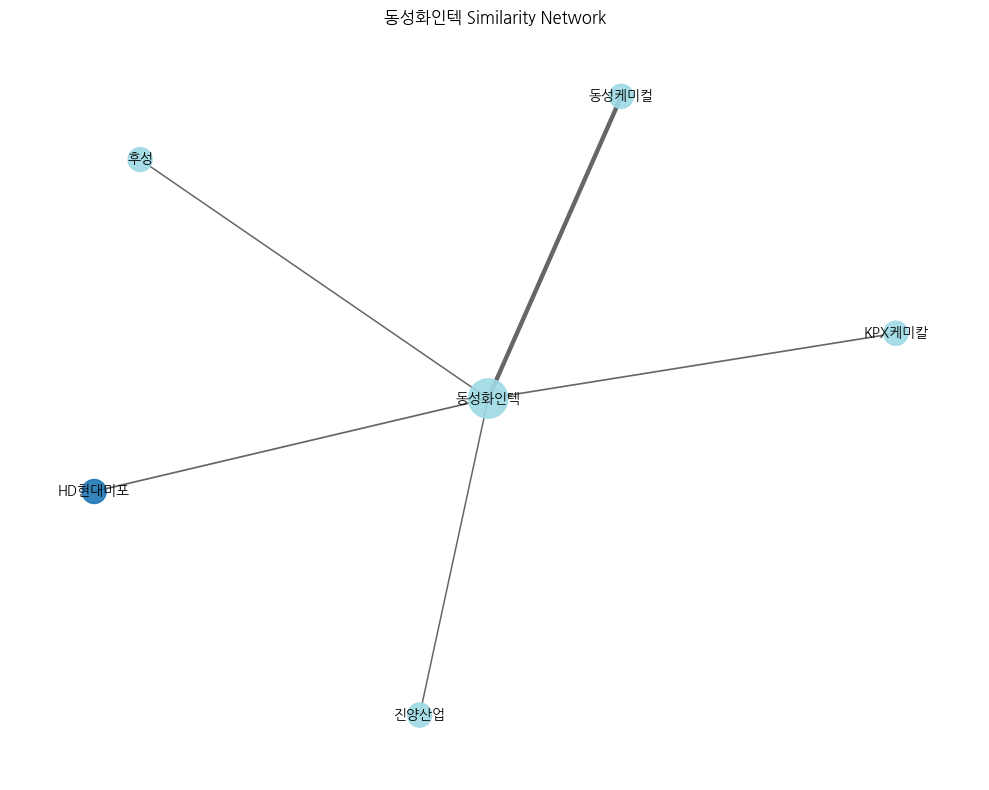

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ===== 폰트: 나눔고딕 =====
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

df = df_sub  # 위에서 만든 서브셋 사용

# 그래프 생성
G = nx.from_pandas_edgelist(
    df,
    source='firm_i',
    target='firm_j',
    edge_attr='similarity',
    create_using=nx.Graph()
)

# 노드 속성: 이름/섹터
for _, row in df.iterrows():
    if row['firm_i'] in G:
        G.nodes[row['firm_i']]['name'] = row['firm_i_name']
        G.nodes[row['firm_i']]['sector'] = row['W_i']
    if row['firm_j'] in G:
        G.nodes[row['firm_j']]['name'] = row['firm_j_name']
        G.nodes[row['firm_j']]['sector'] = row['W_j']

for n in G.nodes():
    if 'sector' not in G.nodes[n] or pd.isna(G.nodes[n]['sector']):
        G.nodes[n]['sector'] = 'Unknown'
    if 'name' not in G.nodes[n] or pd.isna(G.nodes[n]['name']):
        G.nodes[n]['name'] = str(n)

# 색상: sector 기준
sectors = sorted({G.nodes[n]['sector'] for n in G.nodes()})
cmap = plt.get_cmap('tab20', len(sectors))
sector_to_color = {s: cmap(i) for i, s in enumerate(sectors)}
node_colors = [sector_to_color[G.nodes[n]['sector']] for n in G.nodes()]

# 엣지 두께 = similarity
edge_widths = [G[u][v]['similarity'] * 5 for u, v in G.edges()]

# 레이아웃
pos = nx.spring_layout(G, k=2.0, iterations=50, scale=2.0, seed=42)

plt.figure(figsize=(10, 8))

# 노드: 중심 기업은 크게, 나머지는 작게
node_sizes = []
for n in G.nodes():
    if G.nodes[n]['name'] == center_name:
        node_sizes.append(800)
    else:
        node_sizes.append(300)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.6
)

# 라벨: 모든 노드에 이름 표시
labels = {n: G.nodes[n]['name'] for n in G.nodes()}

nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_family='NanumGothic',
    font_size=10   # 조금 키워도 좋아요
)



# 범례
#legend_handles = [Patch(facecolor=sector_to_color[s], label=s) for s in sectors]
#plt.legend(handles=legend_handles, title="Sector (W)", fontsize=8, loc='best')

plt.title(f"{center_name} Similarity Network")
plt.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipykernel_16403/1200035166.py:54: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  w_categories = sorted(pd.unique(w_list))
/tmp/ipykernel_16403/1200035166.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(w_categories), 1))


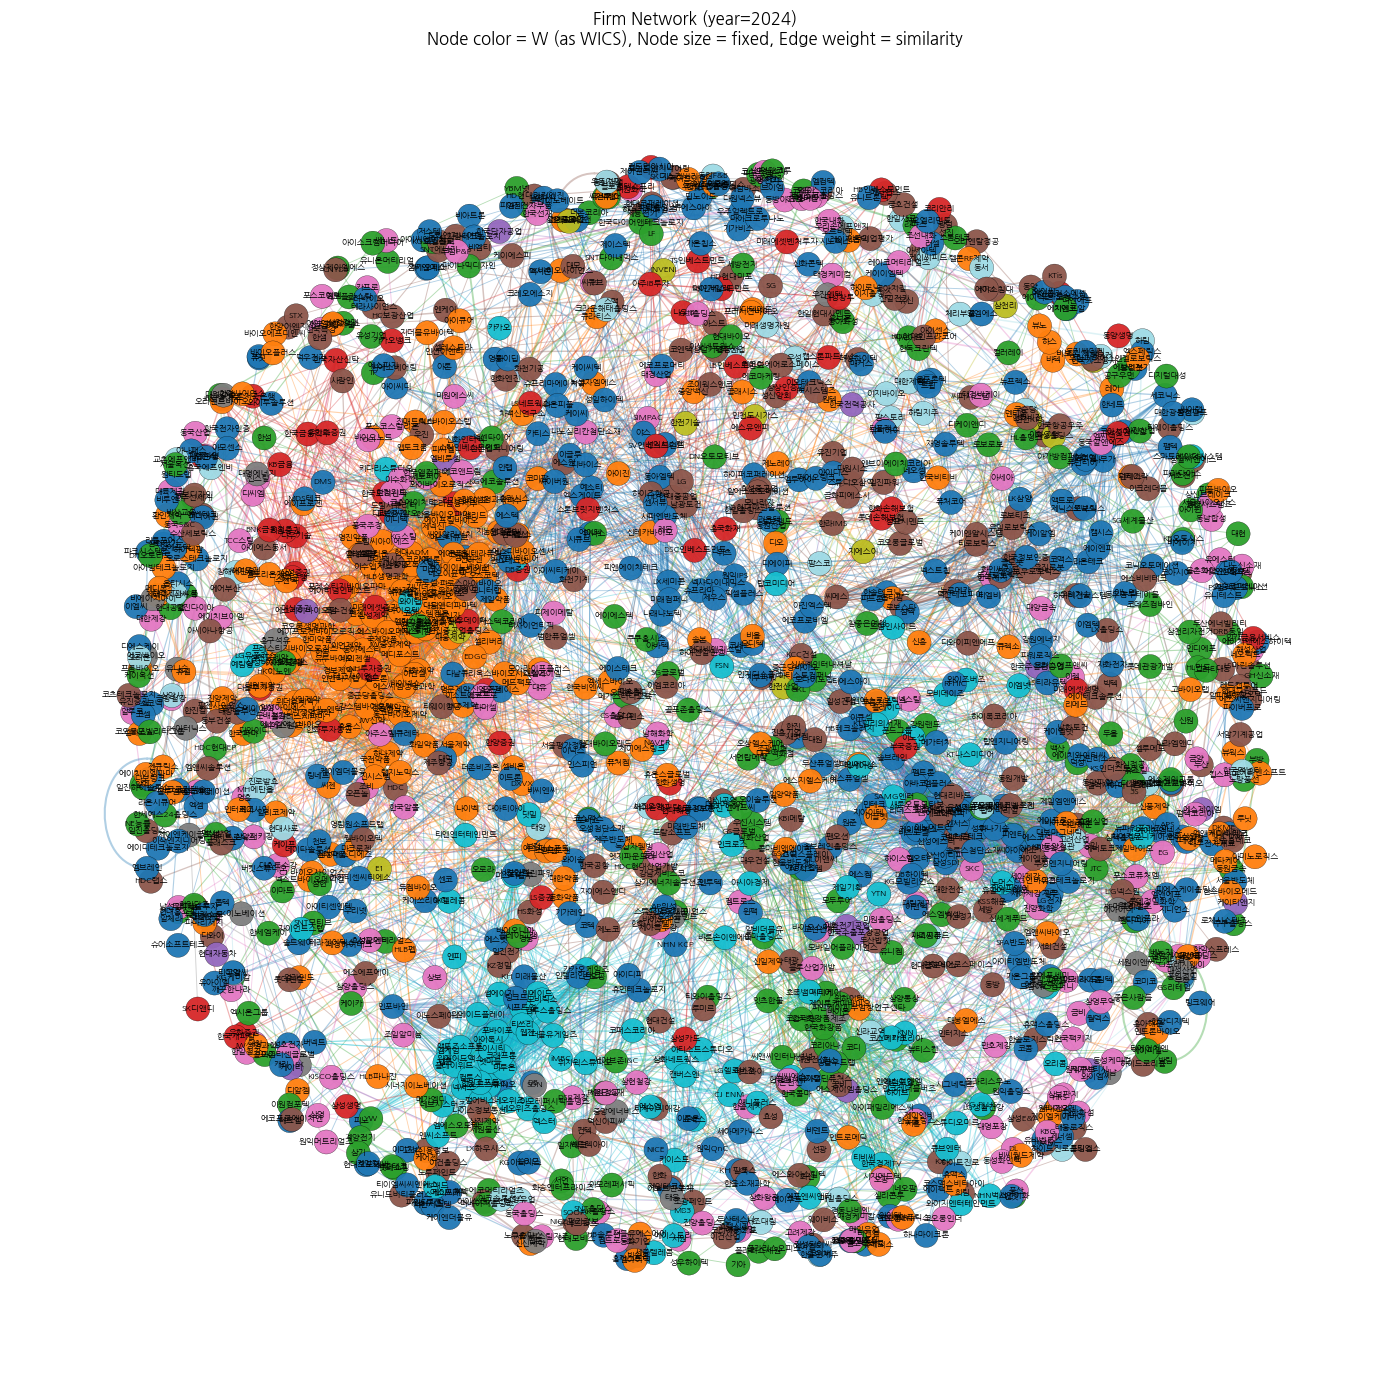

W category mapping:
0 IT
1 건강관리
2 경기관련소비재
3 금융
4 미분류
5 산업재
6 소재
7 에너지
8 유틸리티
9 커뮤니케이션서비스
10 필수소비재


In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1) 특정 연도 선택
year_sel = 2024
df = df_F_m[df_F_m["year"] == year_sel].copy()

# similarity threshold
sim_th = 0.4
df = df[df["similarity"] >= sim_th].copy()

# 2) firm_i / firm_j 양쪽에서 노드 속성(W=섹터 라벨) 모으기
#   df_F_m에는 W_i, W_j가 있으므로 이를 node 속성 W로 통합
nodes_i = df[["firm_i_name", "W_i"]].rename(columns={"firm_i_name": "node", "W_i": "W"})
nodes_j = df[["firm_j_name", "W_j"]].rename(columns={"firm_j_name": "node", "W_j": "W"})
nodes_df = pd.concat([nodes_i, nodes_j], ignore_index=True)

# 같은 node 중복이면 첫 번째 사용
nodes_df = nodes_df.drop_duplicates(subset="node").set_index("node")

w_attr = nodes_df["W"].to_dict()

# 3) 그래프 생성
G = nx.from_pandas_edgelist(
    df,
    source="firm_i_name",
    target="firm_j_name",
    edge_attr="similarity",
    create_using=nx.Graph()
)

# 4) 노드 속성 부여
nx.set_node_attributes(G, w_attr, "W")

# 5) 레이아웃
pos = nx.spring_layout(G, k=0.45, weight="similarity", iterations=100)

# 6) 노드 리스트
nodes = list(G.nodes())

# 7) W를 숫자 코드로 변환 (tab20 같은 컬러맵은 숫자가 편함)
#   W가 문자열(예: '소재', '산업재', 'IT')이므로 카테고리 -> 정수 매핑
w_list_raw = [G.nodes[n].get("W", np.nan) for n in nodes]
w_list = [
    "미분류" if (pd.isna(w) or str(w).strip() == "" or str(w).strip().lower() == "nan")
    else str(w).strip()
    for w in w_list_raw
]
w_categories = sorted(pd.unique(w_list))
w_to_code = {w: i for i, w in enumerate(w_categories)}  # 0..N-1
w_codes = np.array([w_to_code[w] for w in w_list])

# 8) 노드 크기: cap 없으니 고정값 (원하면 degree 기반으로 바꿔도 됨)
node_sizes = 300

# 9) 컬러맵 (카테고리 수만큼)
cmap = plt.cm.get_cmap("tab20", max(len(w_categories), 1))

plt.figure(figsize=(14, 14))

# 엣지별 색: u의 W 코드로 칠하기
edge_colors = []
for u, v in G.edges():
    w_u = G.nodes[u].get("W", np.nan)

    # w_list와 동일하게 정규화
    if pd.isna(w_u) or str(w_u).strip() == "" or str(w_u).strip().lower() == "nan":
        w_u = "미분류"
    else:
        w_u = str(w_u).strip()

    code = w_to_code[w_u]
    edge_colors.append(cmap(code / max(len(w_categories) - 1, 1)))

nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=[G[u][v]["similarity"] * 1.5 for u, v in G.edges()],
    alpha=0.35
)

# 노드 (색=W, 크기=고정)
nc = nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodes,
    node_size=node_sizes,
    node_color=w_codes,
    cmap=cmap,
    linewidths=0.2,
    edgecolors="black",
    alpha=0.95
)

# 라벨
nx.draw_networkx_labels(G, pos, font_size=6, font_family='NanumGothic')

plt.title(
    f"Firm Network (year={year_sel})\nNode color = W (as WICS), Node size = fixed, Edge weight = similarity"
)
plt.axis("off")
plt.tight_layout()
plt.show()

# 범례용 매핑 확인 (선택)
print("W category mapping:")
for k, v in w_to_code.items():
    print(v, k)
